# Hand Detection using CNN
![Hand Detection](https://user-images.githubusercontent.com/50156227/166168918-a5caff72-e068-41ac-b1cb-91b79a8a1311.gif)
<br>
<h4><b>Model is ready to be used for apps & APIs, (check the last cell for 'How to use')</b></h4>

In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from pathlib import Path
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Dense, Add, Conv2D, SeparableConv2D
from tensorflow.keras.layers import BatchNormalization, AveragePooling2D
from tensorflow.keras.layers import LeakyReLU, MaxPooling2D, Flatten
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import backend as K

In [2]:
IMG_HEIGHT = 416
IMG_WIDTH = 416
X_FACTOR = IMG_WIDTH / 600 # 600 is dataset images shape
Y_FACTOR = IMG_HEIGHT / 600
BATCH_SIZE = 128
EPOCHS = 35
learning_rate = 0.0032
dataset_path = '../input/hand-detection-dataset-factory/hands'

In [3]:
def grabPaths(filepath):
    labels = [str(filepath[i]).split("/")[-1] \
              for i in range(len(filepath))]
    filepath = pd.Series(filepath, name='path').astype(str)
    df = pd.DataFrame(filepath)    
    return df

def rescale_boxes(boxes):
    # Rescale boxes (since we resscaled images sizes)
    boxes = np.array(boxes).astype(np.float32)
    boxes[:,[0,2]] = boxes[:,[0,2]] * X_FACTOR
    boxes[:,[1,3]] = boxes[:,[1,3]] * Y_FACTOR
    return boxes

def inverse_rescale_boxes(boxes):
    # Inverse scale of box coordinates
    # You should inverse scale based on the image
    boxes[:,[0,2]] = boxes[:,[0,2]] / X_FACTOR
    boxes[:,[1,3]] = boxes[:,[1,3]] / Y_FACTOR
    return boxes


def plot_bbox(image, yt_box, yp_box=None, norm=False):
    # Given an image and box coordinates, draw the box on the image
    if norm:
        image = image * 255.
        image = image.astype("uint8")
    
    try:
        pil_img = Image.fromarray(image)
    except:
        pil_img = Image.fromarray(image.astype('uint8'))
        
    draw_img = ImageDraw.Draw(pil_img)
    
    x1, y1, w, h = yt_box
    x2, y2 = x1+w, y1+h
    draw_img.rectangle((x1, y1, x2, y2), outline='green')
    
    if yp_box is not None:
        x1, y1, w, h = yp_box
        x2, y2 = x1+w, y1+h
        draw_img.rectangle((x1, y1, x2, y2), outline='red')
    return pil_img


def convblock(previous_layer, n_filters, filter_windows=(3,3,3), padding='same', pool=None):
    # [DepthwiseConv -> BatchNorm -> LeakyReLU] x3 + Residual connection -> Pooling (optional)

    x = SeparableConv2D(n_filters[0], filter_windows[0], padding=padding)(previous_layer)
    x_short = x
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = SeparableConv2D(n_filters[1], filter_windows[1], padding=padding)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = SeparableConv2D(n_filters[2], filter_windows[2], padding=padding)(x)
    x = BatchNormalization()(x)
    x = Add()([x, x_short])
    x = LeakyReLU()(x)
    
    if pool == 'max':
        x = MaxPooling2D(pool_size=(2,2))(x)
    elif pool == 'avg':
        x = AveragePooling2D(pool_size=(2,2))(x)
    
    return x


# Function to calculate MSE Loss function
# for samples where object exists
def custom_mse(y_true, y_pred):
    mask = K.not_equal(K.sum(y_true, axis=1), 0.0)
    y_true_custom = y_true[mask]
    y_pred_custom = y_pred[mask]
    mse = tf.keras.losses.MeanSquaredError()
    result = mse(y_true_custom, y_pred_custom) # * 0.3
    return result


# Function to preview samples of the dataset
def visualize_samples(datagen, row_col_len=4, figsize=None):
    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)
    for i in range(row_col_len):
        for j in range(row_col_len):
            batch_index = np.random.randint(0, BATCH_SIZE/2)
            output_classes = np.array(datagen[batch_index][1]['class_out'])
            classes_true = np.where(output_classes == 1)[0]
            sample_index = classes_true[np.random.randint(0, classes_true.shape[0])]
            image = datagen[batch_index][0][sample_index]
            box = datagen[batch_index][1]['box_out'][sample_index]
            plotted_box = plot_bbox(image, box, norm=True)
            ax[i,j].imshow(plotted_box)
            ax[i,j].set_axis_off()
    plt.show()
    

# Function to make a prediction during training
def visualize_prediction(model, data):    
    # Select a sample where an object exists
    output_classes = np.array(data[0][1]['class_out'])
    sample_index = np.where(output_classes == 1)[0]
    sample_index = sample_index[0] if sample_index[0] else 0 
    
    # Get image
    image = np.array([data[0][0][sample_index]])
    
    # Set y_true & y_pred for class & bounding box
    yt_box = np.array([data[0][1]['box_out'][sample_index]])
    yt_class = np.array([data[0][1]['class_out'][sample_index]])
    yp_class, yp_box = model.predict(image)

    # Plot bounding box on image & show it
    image_plotted = plot_bbox(image[0], yt_box[0], yp_box[0], norm=True) 
    plt.imshow(image_plotted)
    plt.axis('off')
    
    # Print y_true class & y_pred class
    print("Class: y_true=", yt_class, " | y_pred=", int(yp_class >= 0.5))
    plt.show()

In [4]:
# Read CSV
dataset = pd.read_csv('../input/hand-detection-dataset-factory/dataset.csv')

# REMOVE THE LINE BELOW TO USE ALL SAMPLES
# dataset = dataset.sample(n=15000)


dataset.columns = ['path', 'object_exists', 'x', 'y', 'w', 'h']


# List directories of files
train_image_dir_hand = Path(dataset_path)
train_filepaths_hand = list(train_image_dir_hand.glob(r'**/*.png'))

# Create dataframe of {paths, labels}
train_df_hand = grabPaths(train_filepaths_hand)
dataset['path'] = "../input/hand-detection-dataset-factory/hands/" + dataset['path']

# Resize boxes
dataset.iloc[:,2:] = rescale_boxes(dataset.iloc[:,2:])

In [5]:
train_df, test_df = train_test_split(dataset, test_size=0.2)

In [6]:
class MultiOutputGen(tf.keras.utils.Sequence):
    def __init__(self, input_gen, output_gen):
        self.inpgen = input_gen
        self.outgen = output_gen

    def __len__(self):
        return len(self.inpgen)

    def __getitem__(self, i):
        images = self.inpgen[i]
        start = i * images.shape[0]
        end = (i+1) * images.shape[0]
        classes_num = self.outgen.iloc[start:end,0].values
        x = self.outgen.iloc[start:end,1]
        y = self.outgen.iloc[start:end,2]
        w = self.outgen.iloc[start:end,3]
        h = self.outgen.iloc[start:end,4]
#         return images, np.array([x, y, w, h]).T
        return images, {'class_out':classes_num, 'box_out':np.array([x, y, w, h]).T}

    def on_epoch_end(self):
        self.inpgen.on_epoch_end()
    
# Class to visualize predictions during training
class VisualOutput(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        global custom_test_gen
        visualize_prediction(self.model, custom_test_gen)

In [7]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    brightness_range=(0.8, 1.2),
    rescale = 1./255.,
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255.,
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='rgb',
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='rgb',
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False,
)


custom_train_gen = MultiOutputGen(train_images, train_df.iloc[:,1:])
custom_test_gen = MultiOutputGen(test_images, test_df.iloc[:,1:])

Found 24000 validated image filenames.
Found 6000 validated image filenames.


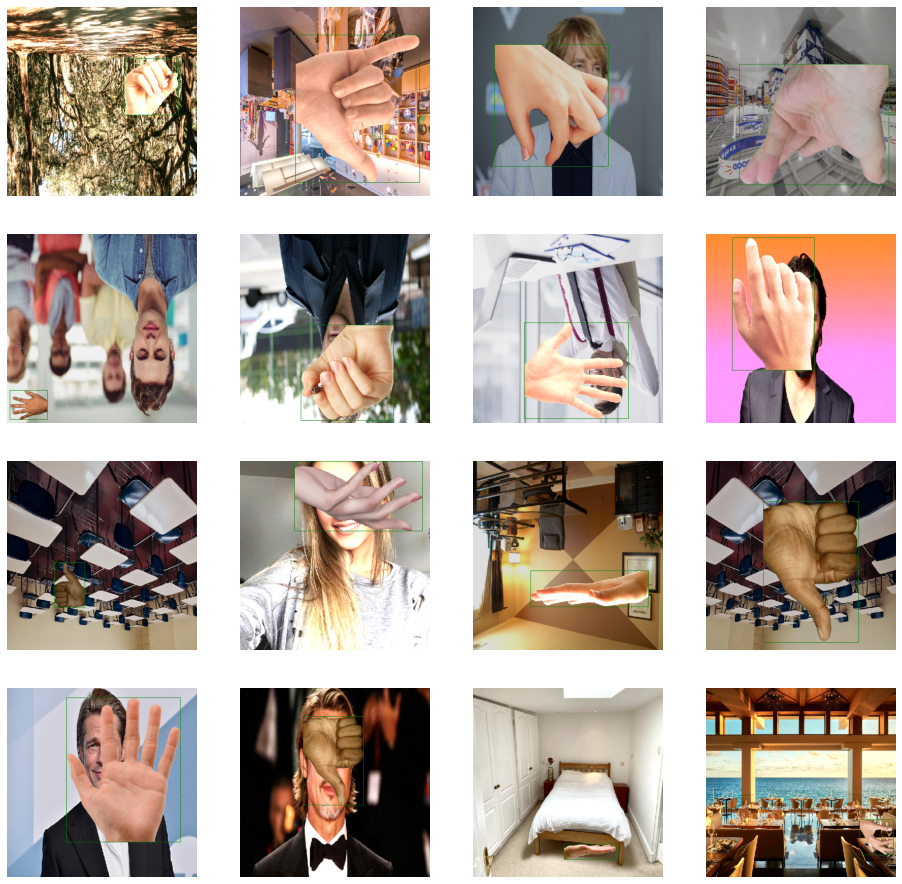

In [8]:
visualize_samples(custom_train_gen)

In [9]:
# BEST MODEL

inp = Input(shape=(IMG_HEIGHT,IMG_WIDTH,3), name='image')

X = SeparableConv2D(64, (7,7), strides=2, padding='valid')(inp)
X = MaxPooling2D(pool_size=(2,2), strides=2)(X)

X = SeparableConv2D(192, (3,3), strides=1, padding='same')(X)
X = MaxPooling2D(pool_size=(2,2), strides=2)(X)

X = convblock(X, [16, 16, 16], pool='max')
X = convblock(X, [32, 32, 32], pool='max')
X = convblock(X, [64, 64, 64], pool='max')
X = convblock(X, [128, 128, 128], pool='max')
X = convblock(X, [256, 256, 256])

X = Flatten()(X)

Xbox = Dense(1024)(X)
Xbox = LeakyReLU()(Xbox)

Xhand = Dense(512)(X)
Xhand = LeakyReLU()(Xhand)


box_output = Dense(4, name='box_out')(Xbox)
class_output = Dense(1, activation='sigmoid', name='class_out')(Xhand)

model = Model(inp, [class_output, box_output])
model.summary()

2022-05-25 23:00:01.926295: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 23:00:02.040080: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 23:00:02.040991: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 23:00:02.042422: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 205, 205, 64) 403         image[0][0]                      
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 102, 102, 64) 0           separable_conv2d[0][0]           
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 102, 102, 192 13056       max_pooling2d[0][0]              
______________________________________________________________________________________________

In [10]:
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

save_best_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='./best_hand_detection.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_box_out_loss",
    factor=tf.math.exp(-0.15),
    patience=2,
    verbose=1,
    mode="min",
    min_lr=0.0004,
)

model.compile(
    loss={'box_out':custom_mse, 'class_out':'binary_crossentropy'},
    optimizer=adam,
    metrics={'class_out':'accuracy'}
)

2022-05-25 23:00:10.398961: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/35


2022-05-25 23:00:18.905728: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


188/188 [==============================] - 991s 5s/step - loss: 3684.5298 - class_out_loss: 0.5587 - box_out_loss: 3683.9727 - class_out_accuracy: 0.7803 - val_loss: 14247.7227 - val_class_out_loss: 1.2213 - val_box_out_loss: 14246.5010 - val_class_out_accuracy: 0.5022
Class: y_true= [1]  | y_pred= 0


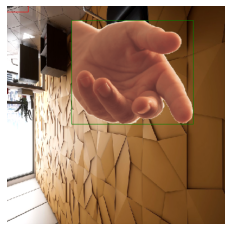

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/35
188/188 [==============================] - 906s 5s/step - loss: 2038.7410 - class_out_loss: 0.2576 - box_out_loss: 2038.4825 - class_out_accuracy: 0.9019 - val_loss: 10955.0596 - val_class_out_loss: 3.0688 - val_box_out_loss: 10951.9902 - val_class_out_accuracy: 0.5022
Class: y_true= [1]  | y_pred= 0


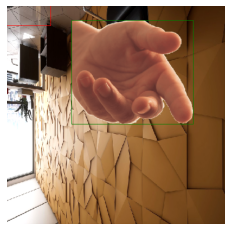

Epoch 3/35
188/188 [==============================] - 899s 5s/step - loss: 1493.3365 - class_out_loss: 0.1881 - box_out_loss: 1493.1482 - class_out_accuracy: 0.9327 - val_loss: 5845.1538 - val_class_out_loss: 0.7679 - val_box_out_loss: 5844.3882 - val_class_out_accuracy: 0.7400
Class: y_true= [1]  | y_pred= 1


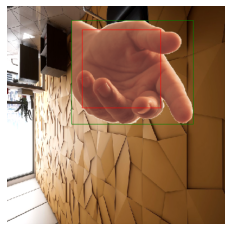

Epoch 4/35
188/188 [==============================] - 908s 5s/step - loss: 1127.1075 - class_out_loss: 0.1385 - box_out_loss: 1126.9692 - class_out_accuracy: 0.9532 - val_loss: 4183.2871 - val_class_out_loss: 0.4152 - val_box_out_loss: 4182.8726 - val_class_out_accuracy: 0.8110
Class: y_true= [1]  | y_pred= 0


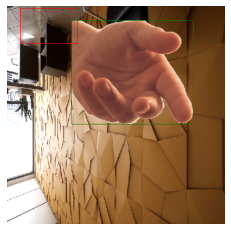

Epoch 5/35
188/188 [==============================] - 927s 5s/step - loss: 1061.8167 - class_out_loss: 0.1455 - box_out_loss: 1061.6711 - class_out_accuracy: 0.9528 - val_loss: 5808.1465 - val_class_out_loss: 1.1401 - val_box_out_loss: 5807.0068 - val_class_out_accuracy: 0.7632
Class: y_true= [1]  | y_pred= 1


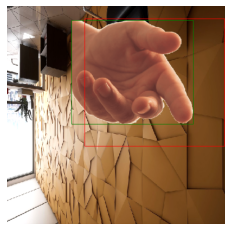

Epoch 6/35
188/188 [==============================] - 896s 5s/step - loss: 928.8773 - class_out_loss: 0.1263 - box_out_loss: 928.7505 - class_out_accuracy: 0.9592 - val_loss: 2026.2935 - val_class_out_loss: 0.3068 - val_box_out_loss: 2025.9867 - val_class_out_accuracy: 0.9118
Class: y_true= [1]  | y_pred= 1


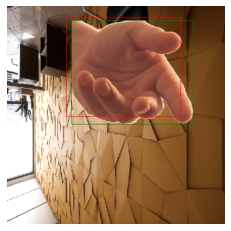

Epoch 7/35
188/188 [==============================] - 905s 5s/step - loss: 799.1411 - class_out_loss: 0.1045 - box_out_loss: 799.0368 - class_out_accuracy: 0.9685 - val_loss: 3233.8899 - val_class_out_loss: 0.7415 - val_box_out_loss: 3233.1489 - val_class_out_accuracy: 0.8043
Class: y_true= [1]  | y_pred= 1


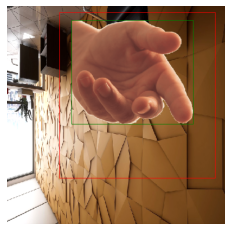

Epoch 8/35
188/188 [==============================] - 915s 5s/step - loss: 673.6833 - class_out_loss: 0.0922 - box_out_loss: 673.5911 - class_out_accuracy: 0.9732 - val_loss: 1431.0009 - val_class_out_loss: 0.1744 - val_box_out_loss: 1430.8263 - val_class_out_accuracy: 0.9473
Class: y_true= [1]  | y_pred= 1


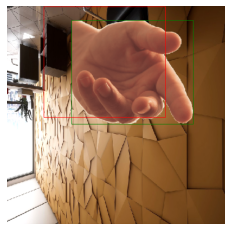

Epoch 9/35
188/188 [==============================] - 945s 5s/step - loss: 651.6602 - class_out_loss: 0.0804 - box_out_loss: 651.5799 - class_out_accuracy: 0.9778 - val_loss: 1102.2654 - val_class_out_loss: 0.2053 - val_box_out_loss: 1102.0598 - val_class_out_accuracy: 0.9427
Class: y_true= [1]  | y_pred= 1


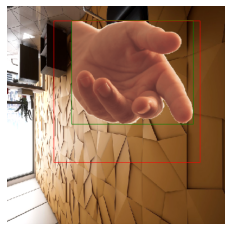

Epoch 10/35
188/188 [==============================] - 945s 5s/step - loss: 641.2216 - class_out_loss: 0.0900 - box_out_loss: 641.1316 - class_out_accuracy: 0.9735 - val_loss: 1386.9999 - val_class_out_loss: 0.2160 - val_box_out_loss: 1386.7836 - val_class_out_accuracy: 0.9417
Class: y_true= [1]  | y_pred= 1


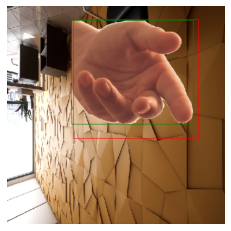

Epoch 11/35
188/188 [==============================] - 917s 5s/step - loss: 500.9124 - class_out_loss: 0.0654 - box_out_loss: 500.8469 - class_out_accuracy: 0.9825 - val_loss: 1108.3734 - val_class_out_loss: 0.2263 - val_box_out_loss: 1108.1472 - val_class_out_accuracy: 0.9505

Epoch 00011: ReduceLROnPlateau reducing learning rate to tf.Tensor(0.0027542654, shape=(), dtype=float32).
Class: y_true= [1]  | y_pred= 1


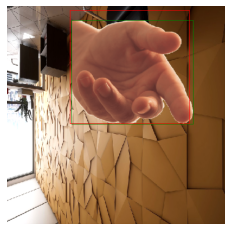

Epoch 12/35
188/188 [==============================] - 904s 5s/step - loss: 457.9219 - class_out_loss: 0.0630 - box_out_loss: 457.8588 - class_out_accuracy: 0.9830 - val_loss: 2627.6621 - val_class_out_loss: 0.7719 - val_box_out_loss: 2626.8906 - val_class_out_accuracy: 0.8268
Class: y_true= [1]  | y_pred= 1


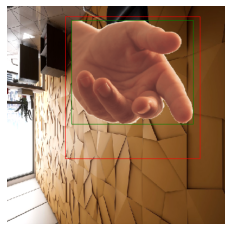

Epoch 13/35
188/188 [==============================] - 916s 5s/step - loss: 391.0279 - class_out_loss: 0.0499 - box_out_loss: 390.9779 - class_out_accuracy: 0.9877 - val_loss: 1139.7380 - val_class_out_loss: 0.1791 - val_box_out_loss: 1139.5588 - val_class_out_accuracy: 0.9632

Epoch 00013: ReduceLROnPlateau reducing learning rate to tf.Tensor(0.002370618, shape=(), dtype=float32).
Class: y_true= [1]  | y_pred= 1


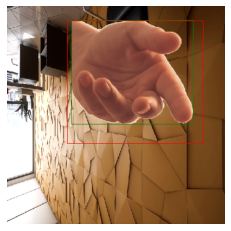

Epoch 14/35
188/188 [==============================] - 921s 5s/step - loss: 337.3167 - class_out_loss: 0.0469 - box_out_loss: 337.2698 - class_out_accuracy: 0.9882 - val_loss: 1315.4137 - val_class_out_loss: 0.3626 - val_box_out_loss: 1315.0510 - val_class_out_accuracy: 0.8972
Class: y_true= [1]  | y_pred= 1


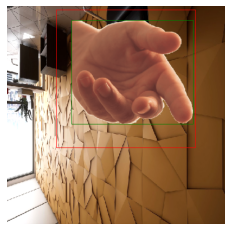

Epoch 15/35
188/188 [==============================] - 918s 5s/step - loss: 322.1905 - class_out_loss: 0.0387 - box_out_loss: 322.1518 - class_out_accuracy: 0.9905 - val_loss: 2736.6858 - val_class_out_loss: 0.3345 - val_box_out_loss: 2736.3516 - val_class_out_accuracy: 0.8573

Epoch 00015: ReduceLROnPlateau reducing learning rate to tf.Tensor(0.0020404097, shape=(), dtype=float32).
Class: y_true= [1]  | y_pred= 1


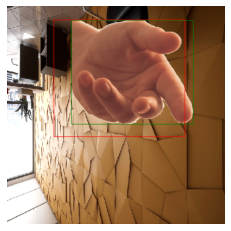

Epoch 16/35
188/188 [==============================] - 903s 5s/step - loss: 290.1945 - class_out_loss: 0.0346 - box_out_loss: 290.1600 - class_out_accuracy: 0.9923 - val_loss: 1127.6855 - val_class_out_loss: 0.2411 - val_box_out_loss: 1127.4442 - val_class_out_accuracy: 0.9505
Class: y_true= [1]  | y_pred= 1


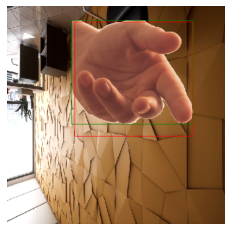

Epoch 17/35
188/188 [==============================] - 920s 5s/step - loss: 317.7131 - class_out_loss: 0.0387 - box_out_loss: 317.6744 - class_out_accuracy: 0.9901 - val_loss: 1912.7719 - val_class_out_loss: 0.4589 - val_box_out_loss: 1912.3126 - val_class_out_accuracy: 0.8765

Epoch 00017: ReduceLROnPlateau reducing learning rate to tf.Tensor(0.0017561968, shape=(), dtype=float32).
Class: y_true= [1]  | y_pred= 1


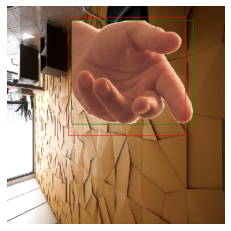

Epoch 18/35
188/188 [==============================] - 935s 5s/step - loss: 230.8961 - class_out_loss: 0.0265 - box_out_loss: 230.8696 - class_out_accuracy: 0.9941 - val_loss: 789.6093 - val_class_out_loss: 0.1284 - val_box_out_loss: 789.4807 - val_class_out_accuracy: 0.9702
Class: y_true= [1]  | y_pred= 1


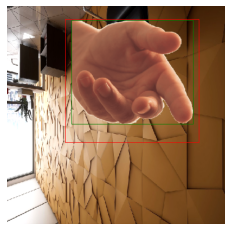

Epoch 19/35
188/188 [==============================] - 944s 5s/step - loss: 193.9854 - class_out_loss: 0.0206 - box_out_loss: 193.9648 - class_out_accuracy: 0.9958 - val_loss: 674.0159 - val_class_out_loss: 0.1155 - val_box_out_loss: 673.9005 - val_class_out_accuracy: 0.9772
Class: y_true= [1]  | y_pred= 1


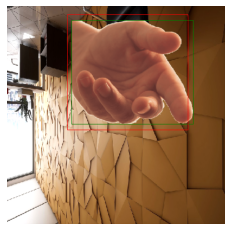

Epoch 20/35
188/188 [==============================] - 910s 5s/step - loss: 221.7292 - class_out_loss: 0.0238 - box_out_loss: 221.7054 - class_out_accuracy: 0.9933 - val_loss: 602.3969 - val_class_out_loss: 0.1095 - val_box_out_loss: 602.2874 - val_class_out_accuracy: 0.9817
Class: y_true= [1]  | y_pred= 1


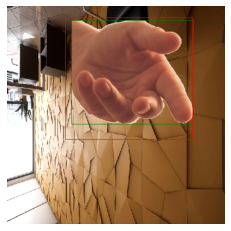

Epoch 21/35
188/188 [==============================] - 916s 5s/step - loss: 174.6269 - class_out_loss: 0.0174 - box_out_loss: 174.6095 - class_out_accuracy: 0.9961 - val_loss: 489.8862 - val_class_out_loss: 0.1022 - val_box_out_loss: 489.7840 - val_class_out_accuracy: 0.9853
Class: y_true= [1]  | y_pred= 1


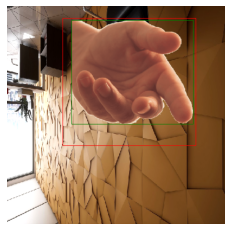

Epoch 22/35
188/188 [==============================] - 920s 5s/step - loss: 165.0588 - class_out_loss: 0.0155 - box_out_loss: 165.0434 - class_out_accuracy: 0.9960 - val_loss: 536.9653 - val_class_out_loss: 0.0859 - val_box_out_loss: 536.8794 - val_class_out_accuracy: 0.9857
Class: y_true= [1]  | y_pred= 1


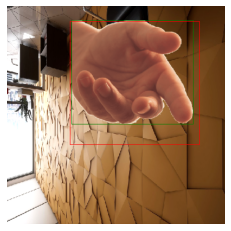

Epoch 23/35
188/188 [==============================] - 909s 5s/step - loss: 199.1950 - class_out_loss: 0.0223 - box_out_loss: 199.1727 - class_out_accuracy: 0.9945 - val_loss: 943.8217 - val_class_out_loss: 0.1584 - val_box_out_loss: 943.6633 - val_class_out_accuracy: 0.9613

Epoch 00023: ReduceLROnPlateau reducing learning rate to tf.Tensor(0.0015115725, shape=(), dtype=float32).
Class: y_true= [1]  | y_pred= 1


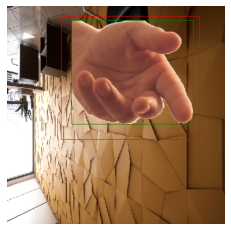

Epoch 24/35
188/188 [==============================] - 921s 5s/step - loss: 290.8307 - class_out_loss: 0.0337 - box_out_loss: 290.7969 - class_out_accuracy: 0.9901 - val_loss: 1104.0532 - val_class_out_loss: 0.1944 - val_box_out_loss: 1103.8586 - val_class_out_accuracy: 0.9625
Class: y_true= [1]  | y_pred= 1


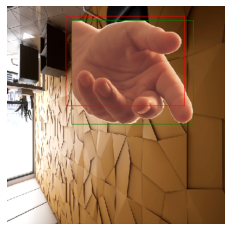

Epoch 25/35
188/188 [==============================] - 963s 5s/step - loss: 268.6223 - class_out_loss: 0.0305 - box_out_loss: 268.5917 - class_out_accuracy: 0.9916 - val_loss: 511.7187 - val_class_out_loss: 0.0991 - val_box_out_loss: 511.6196 - val_class_out_accuracy: 0.9840

Epoch 00025: ReduceLROnPlateau reducing learning rate to tf.Tensor(0.0013010225, shape=(), dtype=float32).
Class: y_true= [1]  | y_pred= 1


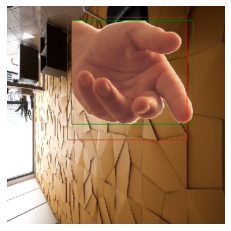

Epoch 26/35
188/188 [==============================] - 928s 5s/step - loss: 146.5772 - class_out_loss: 0.0118 - box_out_loss: 146.5655 - class_out_accuracy: 0.9967 - val_loss: 785.0436 - val_class_out_loss: 0.0948 - val_box_out_loss: 784.9487 - val_class_out_accuracy: 0.9805
Class: y_true= [1]  | y_pred= 1


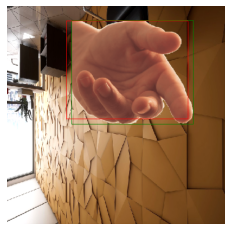

Epoch 27/35
188/188 [==============================] - 946s 5s/step - loss: 141.5741 - class_out_loss: 0.0099 - box_out_loss: 141.5641 - class_out_accuracy: 0.9972 - val_loss: 503.7231 - val_class_out_loss: 0.1160 - val_box_out_loss: 503.6071 - val_class_out_accuracy: 0.9818

Epoch 00027: ReduceLROnPlateau reducing learning rate to tf.Tensor(0.0011198004, shape=(), dtype=float32).
Class: y_true= [1]  | y_pred= 1


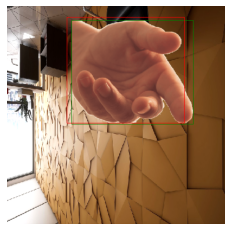

Epoch 28/35
188/188 [==============================] - 1002s 5s/step - loss: 113.0649 - class_out_loss: 0.0075 - box_out_loss: 113.0574 - class_out_accuracy: 0.9978 - val_loss: 499.8904 - val_class_out_loss: 0.1291 - val_box_out_loss: 499.7614 - val_class_out_accuracy: 0.9842
Class: y_true= [1]  | y_pred= 1


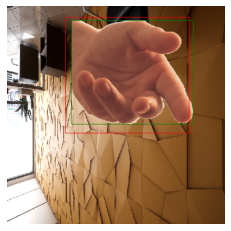

Epoch 29/35
188/188 [==============================] - 1023s 5s/step - loss: 102.3193 - class_out_loss: 0.0061 - box_out_loss: 102.3132 - class_out_accuracy: 0.9984 - val_loss: 505.0919 - val_class_out_loss: 0.1006 - val_box_out_loss: 504.9913 - val_class_out_accuracy: 0.9850

Epoch 00029: ReduceLROnPlateau reducing learning rate to tf.Tensor(0.0009638211, shape=(), dtype=float32).
Class: y_true= [1]  | y_pred= 1


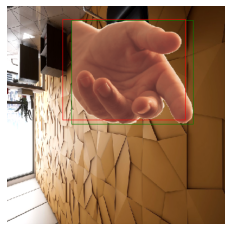

Epoch 30/35
188/188 [==============================] - 1015s 5s/step - loss: 99.1490 - class_out_loss: 0.0063 - box_out_loss: 99.1427 - class_out_accuracy: 0.9984 - val_loss: 442.9694 - val_class_out_loss: 0.1092 - val_box_out_loss: 442.8601 - val_class_out_accuracy: 0.9853
Class: y_true= [1]  | y_pred= 1


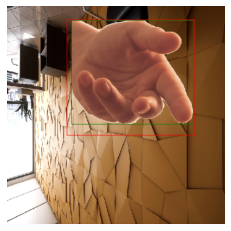

Epoch 31/35
188/188 [==============================] - 1025s 5s/step - loss: 88.5025 - class_out_loss: 0.0059 - box_out_loss: 88.4966 - class_out_accuracy: 0.9987 - val_loss: 453.0609 - val_class_out_loss: 0.1072 - val_box_out_loss: 452.9537 - val_class_out_accuracy: 0.9865
Class: y_true= [1]  | y_pred= 1


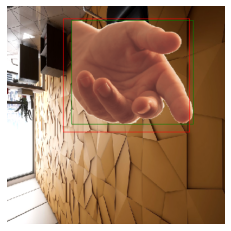

Epoch 32/35
188/188 [==============================] - 1036s 6s/step - loss: 82.7229 - class_out_loss: 0.0061 - box_out_loss: 82.7168 - class_out_accuracy: 0.9983 - val_loss: 432.4265 - val_class_out_loss: 0.1181 - val_box_out_loss: 432.3083 - val_class_out_accuracy: 0.9867
Class: y_true= [1]  | y_pred= 1


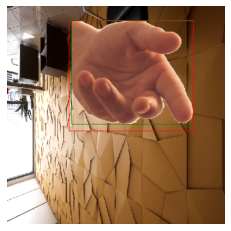

Epoch 33/35
188/188 [==============================] - 1020s 5s/step - loss: 83.4975 - class_out_loss: 0.0084 - box_out_loss: 83.4891 - class_out_accuracy: 0.9979 - val_loss: 436.4131 - val_class_out_loss: 0.1347 - val_box_out_loss: 436.2783 - val_class_out_accuracy: 0.9860
Class: y_true= [1]  | y_pred= 1


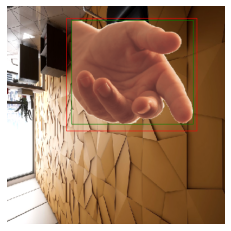

Epoch 34/35
188/188 [==============================] - 991s 5s/step - loss: 83.1572 - class_out_loss: 0.0069 - box_out_loss: 83.1503 - class_out_accuracy: 0.9986 - val_loss: 484.1720 - val_class_out_loss: 0.1224 - val_box_out_loss: 484.0496 - val_class_out_accuracy: 0.9858

Epoch 00034: ReduceLROnPlateau reducing learning rate to tf.Tensor(0.0008295684, shape=(), dtype=float32).
Class: y_true= [1]  | y_pred= 1


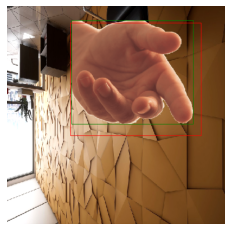

Epoch 35/35
188/188 [==============================] - 1007s 5s/step - loss: 72.9853 - class_out_loss: 0.0035 - box_out_loss: 72.9818 - class_out_accuracy: 0.9992 - val_loss: 626.3461 - val_class_out_loss: 0.1746 - val_box_out_loss: 626.1714 - val_class_out_accuracy: 0.9780
Class: y_true= [1]  | y_pred= 1


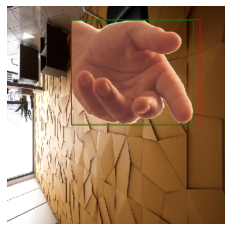

In [11]:
history = model.fit(
    custom_train_gen,
    epochs=EPOCHS,
    validation_data=custom_test_gen,
    callbacks=[
        reduce_lr,
        VisualOutput(),
        save_best_model
    ]
)

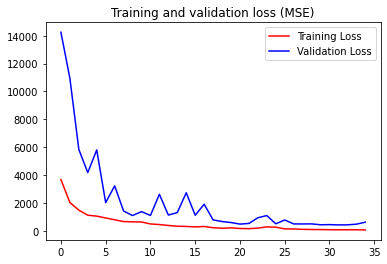

In [12]:
# Loss Graph

%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss (MSE)')
plt.legend()

plt.show()

In [13]:
# Save model for later use

# for python apps (& APIs)
model.save("Hand Detection.h5")

# for mobile apps & microcontrollers (TensorFlow Lite)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("Hand Detection Lite.tflite", 'wb') as file:
    file.write(tflite_model)

2022-05-26 08:16:06.201637: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-05-26 08:16:13.798583: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 08:16:13.799009: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-05-26 08:16:13.800061: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-05-26 08:16:13.801731: I tensorflow/stream_executor/cuda/cuda_gpu_executor.

# How to use the model with Camera (and as API)

1- For APIs, Python Apps
Download 'Hand Detection.h5'.

2- For Non-Python Apps (i.e. mobile, embedded)
Download Lite version for mobile apps
and search for some package to use Tflite (package:tflite for Flutter & Java)

Run the following code in the same folder with the model

In [14]:
# import cv2
# import tensorflow as tf
# from tensorflow.keras import backend as K
# from tensorflow.keras.models import load_model

# # Function to calculate MSE Loss function
# # for samples where object exists
# def custom_mse(y_true, y_pred):
#     mask = K.not_equal(K.sum(y_true, axis=1), 0.0)
#     y_true_custom = y_true[mask]
#     y_pred_custom = y_pred[mask]
#     mse = tf.keras.losses.MeanSquaredError()
#     result = mse(y_true_custom, y_pred_custom) # * 0.3
#     return result

# model = load_model("Hand Detection.h5", custom_objects={'custom_mse':custom_mse})

# IMG_HEIGHT = 416
# IMG_WIDTH = 416

# cam = cv2.VideoCapture(0)
# while True:
#     ret, frame = cam.read()
#     if ret:
        
#         # How to use as API (given img:frame as input)
#         image = cv2.resize(frame, (IMG_WIDTH, IMG_HEIGHT))
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         image = image / 255.
#         yp_class, yp_box = model.predict(np.array([image]))
#         x, y, w, h= yp_box[0]        
#         x, w = round(IMG_WIDTH / (IMG_WIDTH / frame.shape[1]) ), round(IMG_WIDTH / (IMG_WIDTH / frame.shape[1]))
#         y, h = round(IMG_HEIGHT / (IMG_HEIGHT / frame.shape[0])), round(h / (IMG_HEIGHT / frame.shape[0])) # / 560
#         # END: how to use as API
        
#         if yp_class[0] >= 0.5:
#              frame= cv2.rectangle(frame, (x, y), (x+w, y+h), thickness=2, color=(0,255,0))
#         cv2.imshow("mywindow", frame)
#     if cv2.waitKey(1) == ord('q'):
#         break
# cam.release()
# cv2.destroyAllWindows()